# Quickstart or _"How to get 100% return per year"_

First, do some initialization and set debugging level to `debug` to see progress of computation.

In [1]:
%matplotlib inline
import pandas as pd
from universal import tools
from universal import algos
import logging
# we would like to see algos progress
logging.basicConfig(format='%(asctime)s %(message)s', level=logging.DEBUG)
logger = logging.getLogger('matplotlib')
logger.setLevel(logging.ERROR)

import matplotlib
# increase the size of graphs
matplotlib.rcParams['figure.dpi'] = 200

Let's try to replicate the results of B.Li and S.Hoi from their article [On-Line Portfolio Selection with Moving Average Reversion](http://arxiv.org/abs/1206.4626). They claim superior performance on several datasets using their OLMAR algorithm. These datasets are available in `data/` directory in `.pkl` format. Those are all relative prices (start with 1.) and artificial tickers. We can start with NYSE stocks from period 1/1/1985 - 30/6/2010.

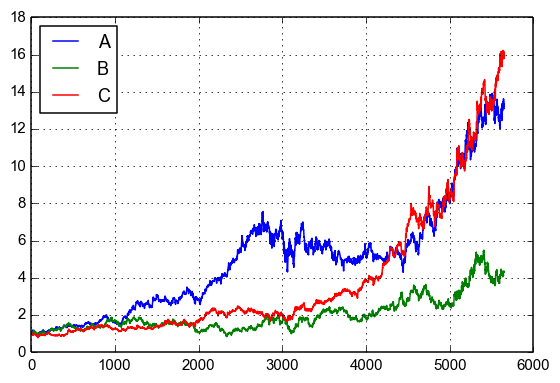

In [2]:
# load data using tools module
data = tools.dataset('nyse_o')

# plot first three of them as example
data.iloc[:,:3].plot()

Now we need an implementation of the OLMAR algorithm. Fortunately, it is already implemented in module `algos`, so all we have to do is load it and set its parameters. Authors recommend lookback window $w = 5$ and threshold $\epsilon = 10$ (these are default parameters anyway). Just call `run` method on our data to get results for analysis.

In [3]:
# set algo parameters
algo = algos.OLMAR(window=5, eps=10)

# run
result = algo.run(data)

2014-02-22 12:11:38,434 Running OLMAR...
2014-02-22 12:11:38,654 Progress: 0%...
2014-02-22 12:11:39,486 Progress: 10%...
2014-02-22 12:11:40,553 Progress: 20%...
2014-02-22 12:11:41,443 Progress: 30%...
2014-02-22 12:11:42,356 Progress: 40%...
2014-02-22 12:11:43,278 Progress: 50%...
2014-02-22 12:11:44,601 Progress: 60%...
2014-02-22 12:11:45,624 Progress: 70%...
2014-02-22 12:11:46,685 Progress: 80%...
2014-02-22 12:11:47,738 Progress: 90%...
2014-02-22 12:11:48,663 OLMAR finished successfully.


Ok, let's see some results. First print some basic summary metrics and plot portfolio equity with UCRP (uniform constant rebalanced portfolio).

2014-02-22 12:11:49,066 Running CRP...
2014-02-22 12:11:49,089 CRP finished successfully.


Summary:
    Profit factor: 1.89
    Sharpe ratio: 3.14
    Information ratio (wrt UCRP): 3.07
    Annualized return: 466.14%
    Longest drawdown: 185 days
    Winning days: 58.3%
        


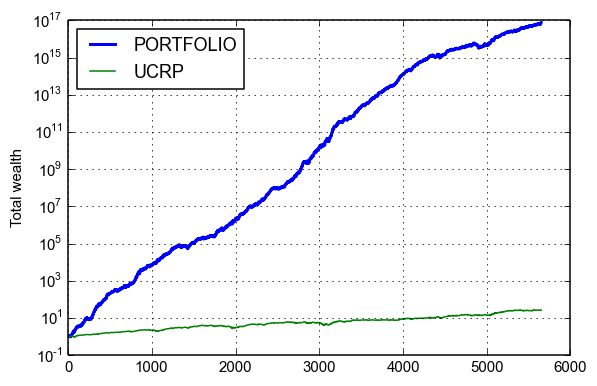

In [4]:
print(result.summary())
result.plot(weights=False, assets=False, ucrp=True, logy=True)

That seems really impressive, in fact it looks too good to be true. Let's see how individual stocks contribute to portfolio equity and disable legend to keep the graph clean.

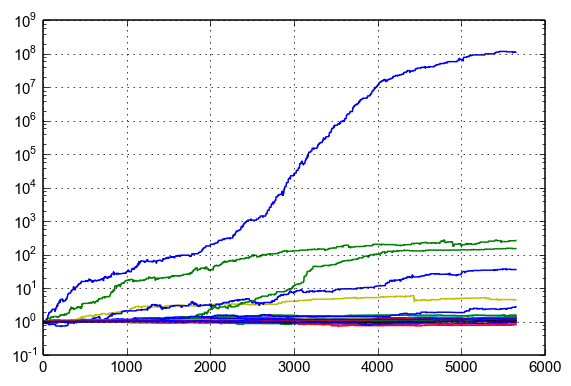

In [5]:
result.plot_decomposition(legend=False, logy=True)

As you can see, almost all wealth comes from single stock (don't forget it has logarithm scale!). So if we used just 5 of all these stocks, we would get almost the same equity as if we used all of them. To stress test the strategy, we can remove that stock and rerun the algorithm.

2014-02-22 12:11:51,827 Running OLMAR...
2014-02-22 12:11:51,869 Progress: 0%...
2014-02-22 12:11:52,818 Progress: 10%...
2014-02-22 12:11:53,742 Progress: 20%...
2014-02-22 12:11:54,607 Progress: 30%...
2014-02-22 12:11:55,441 Progress: 40%...
2014-02-22 12:11:56,352 Progress: 50%...
2014-02-22 12:11:57,222 Progress: 60%...
2014-02-22 12:11:58,084 Progress: 70%...
2014-02-22 12:11:58,924 Progress: 80%...
2014-02-22 12:11:59,788 Progress: 90%...
2014-02-22 12:12:00,631 OLMAR finished successfully.
2014-02-22 12:12:00,796 Running CRP...
2014-02-22 12:12:00,819 CRP finished successfully.


Summary:
    Profit factor: 1.55
    Sharpe ratio: 2.28
    Information ratio (wrt UCRP): 2.16
    Annualized return: 192.81%
    Longest drawdown: 202 days
    Winning days: 56.5%
        


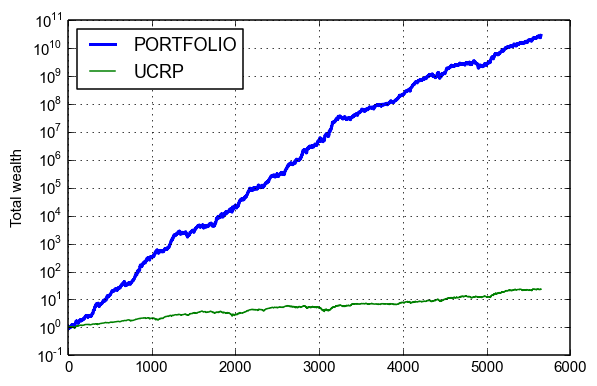

In [6]:
# find name of the most profitable asset
most_profitable = result.equity_decomposed.iloc[-1].argmax()

# rerun an algorithm on data without it
result_without = algo.run(data.drop([most_profitable], 1))

# and print results
print(result_without.summary())
result_without.plot(weights=False, assets=False, ucrp=True, logy=True)

We lost about 7 orders of wealth, but the results are more realistic now. Let's move on and try adding fees of 0.1% per transaction (we pay \$1 for every \$1000 of stocks bought or sold).

2014-02-22 12:12:02,027 Running CRP...
2014-02-22 12:12:02,052 CRP finished successfully.


Summary:
    Profit factor: 1.35
    Sharpe ratio: 1.59
    Information ratio (wrt UCRP): 1.40
    Annualized return: 108.72%
    Longest drawdown: 382 days
    Winning days: 50.2%
        


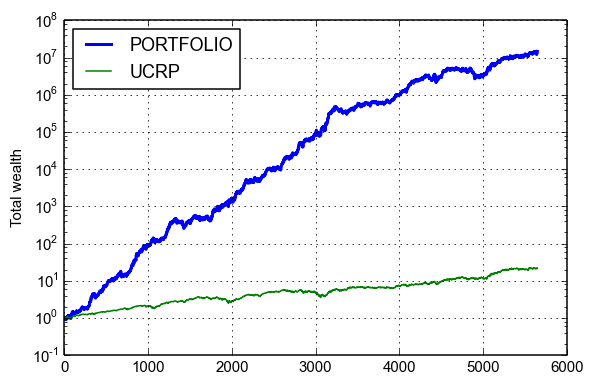

In [7]:
result_without.fee = 0.001
print(result_without.summary())
result_without.plot(weights=False, assets=False, ucrp=True, logy=True)

Results still hold, although our Sharpe ratio decreased from 3.14 to 1.56 and annualized return from 466% to 109%. Now some of you trained in quantitative finance might start asking: "_Isn't there some [survivorship bias](http://en.wikipedia.org/wiki/Survivorship_bias)?_". Yes, it is. In fact, a huge one considering that we have almost 25 years of data and mean-reversion type of strategy.

# Testing Yahoo data

Let's see whether the algo works on recent data, too. First download closing prices of several (randomly chosen) stocks from Yahoo.

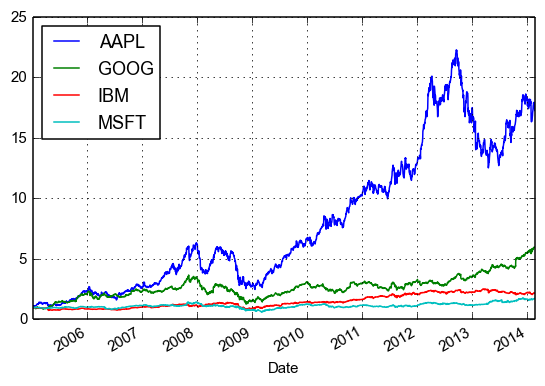

In [8]:
import pandas_datareader as pdr
from datetime import datetime

# load data from Yahoo
yahoo_data = pdr.get_data_yahoo(['MSFT', 'IBM', 'AAPL', 'GOOG'], start=datetime(2005,1,1))['Adj Close']

# plot normalized prices of these stocks
(yahoo_data / yahoo_data.iloc[0,:]).plot()

Instead of using fixed parameters, we will test several `window` parameters with function `run_combination`. It the same as `run`, just use it as classmethod and use lists for combination of values. `run_combination` returns list of results which can be used similarly to `result`.

2014-02-22 12:12:06,515 Run combination of parameters: {'window': 3}
2014-02-22 12:12:06,517 Running OLMAR...
2014-02-22 12:12:06,545 Progress: 0%...
2014-02-22 12:12:06,899 Progress: 10%...
2014-02-22 12:12:07,258 Progress: 20%...
2014-02-22 12:12:07,606 Progress: 30%...
2014-02-22 12:12:07,967 Progress: 40%...
2014-02-22 12:12:08,351 Progress: 50%...
2014-02-22 12:12:08,711 Progress: 60%...
2014-02-22 12:12:09,059 Progress: 70%...
2014-02-22 12:12:09,412 Progress: 80%...
2014-02-22 12:12:09,766 Progress: 90%...
2014-02-22 12:12:10,110 OLMAR finished successfully.
2014-02-22 12:12:10,118 Run combination of parameters: {'window': 5}
2014-02-22 12:12:10,119 Running OLMAR...
2014-02-22 12:12:10,148 Progress: 0%...
2014-02-22 12:12:10,496 Progress: 10%...
2014-02-22 12:12:10,878 Progress: 20%...
2014-02-22 12:12:11,242 Progress: 30%...
2014-02-22 12:12:11,598 Progress: 40%...
2014-02-22 12:12:11,954 Progress: 50%...
2014-02-22 12:12:12,314 Progress: 60%...
2014-02-22 12:12:12,729 Progress

Summary for window=3:
    Profit factor: 1.08
    Sharpe ratio: 0.40
    Information ratio (wrt UCRP): -0.22
    Annualized return: 14.34%
    Longest drawdown: 547 days
    Winning days: 50.3%
        
Summary for window=5:
    Profit factor: 1.10
    Sharpe ratio: 0.50
    Information ratio (wrt UCRP): -0.08
    Annualized return: 18.04%
    Longest drawdown: 392 days
    Winning days: 50.4%
        
Summary for window=10:
    Profit factor: 1.14
    Sharpe ratio: 0.71
    Information ratio (wrt UCRP): 0.23
    Annualized return: 25.86%
    Longest drawdown: 392 days
    Winning days: 50.9%
        
Summary for window=15:
    Profit factor: 1.11
    Sharpe ratio: 0.53
    Information ratio (wrt UCRP): -0.03
    Annualized return: 19.02%
    Longest drawdown: 399 days
    Winning days: 50.5%
        


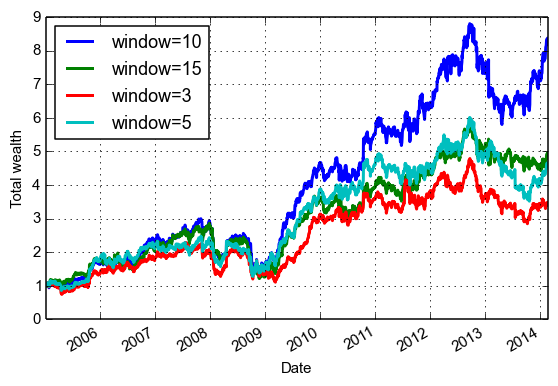

In [9]:
list_result = algos.OLMAR.run_combination(yahoo_data, window=[3,5,10,15], eps=10)
print(list_result.summary())
list_result.plot()

Since we don't know the best parameters in hindsight, we will invest equal money in each of them in the beginning and let them run. This is called _buy and hold_ strategy. Portfolio equities in `list_result` can be regarded as stock prices and used as an input for new algo (_buy and hold_ in this case). This way you can chain algorithms however you like, for example OLMAR on OLMAR, etc.

To compare it with individual assets or uniform constant rebalanced portfolio, use parameters `assets` and `ucrp`.

2014-02-22 12:12:22,002 Running BAH...
2014-02-22 12:12:22,008 BAH finished successfully.
2014-02-22 12:12:22,133 Running CRP...
2014-02-22 12:12:22,135 CRP finished successfully.


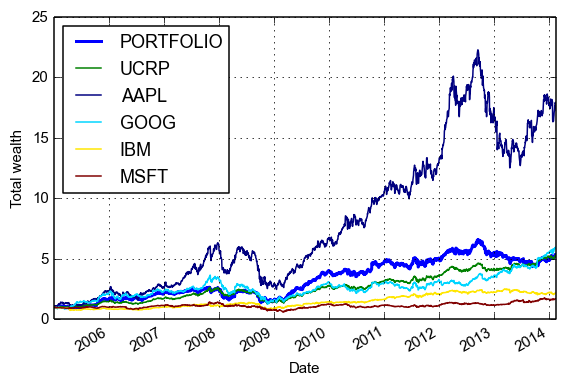

In [10]:
# run buy and hold on OLMAR results and show its equity together with original assets
algos.BAH().run(list_result).plot(assets=True, weights=False, ucrp=True)

Ok, so that was enough for the start. There are plenty of other algorithms in module `algos` collected across research papers about online-portfolios including famous [Universal portfolio](http://en.wikipedia.org/wiki/Universal_portfolio_algorithm) by Thomas Cover.

# How to write your own algorithm

Entire package is actually pretty simple. Algorithms are subclasses of base `Algo` class and methods for reporting, plotting and analysing are built on top of this class. I will illustrate it on this mean-reversion strategy

1. use logarithm of price
2. calculate difference $\delta_i$ between current price of $i$-th stock and its moving average of $n$ days
3. if $\delta_i > 0$, assign zero portfolio weight $w_i = 0$ for $i$-th stock
4. if $\delta_i < 0$, assign weight $w_i = -\delta_i$ for $i$-th stock
5. normalize all weights so that $\sum w_i = 1$

The idea is that badly performing stocks will revert to its mean and have higher returns than those above their mean. Here is the complete code, comments should be self-explanatory.

In [11]:
from universal.algo import Algo
import numpy as np

class MeanReversion(Algo):
    # use logarithm of prices
    PRICE_TYPE = 'log'
    
    def __init__(self, n):
        # length of moving average
        self.n = n
        # step function will be called after min_history days
        super(MeanReversion, self).__init__(min_history=n)
    
    
    def init_weights(self, m):
        # use zero weights for start
        return np.zeros(m)
    
    
    def step(self, x, last_b, history):
        # calculate moving average
        ma = history.iloc[-self.n:].mean()
        
        # weights
        delta = x - ma
        w = np.maximum(-delta, 0.)
        
        # normalize so that they sum to 1
        return w / sum(w)

That's all. Now let's try it on nyse data.

2014-02-22 12:12:23,145 Running MeanReversion...
2014-02-22 12:12:23,180 Progress: 0%...
2014-02-22 12:12:23,712 Progress: 10%...
2014-02-22 12:12:24,224 Progress: 20%...
2014-02-22 12:12:24,778 Progress: 30%...
2014-02-22 12:12:25,294 Progress: 40%...
2014-02-22 12:12:25,887 Progress: 50%...
2014-02-22 12:12:26,467 Progress: 60%...
2014-02-22 12:12:26,975 Progress: 70%...
2014-02-22 12:12:27,498 Progress: 80%...
2014-02-22 12:12:28,013 Progress: 90%...
2014-02-22 12:12:28,517 MeanReversion finished successfully.
2014-02-22 12:12:28,677 Running CRP...
2014-02-22 12:12:28,695 CRP finished successfully.


Summary:
    Profit factor: 1.46
    Sharpe ratio: 2.04
    Information ratio (wrt UCRP): 1.87
    Annualized return: 60.52%
    Longest drawdown: 808 days
    Winning days: 52.3%
        


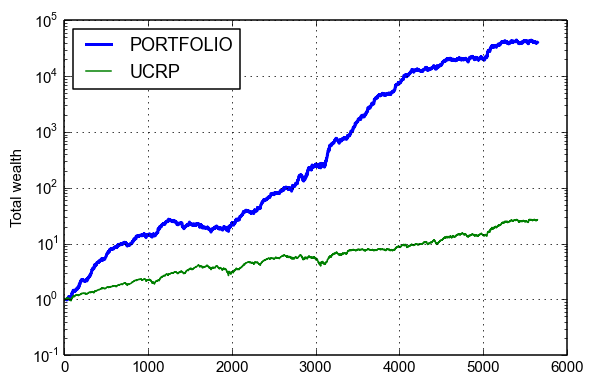

In [12]:
mr = MeanReversion(n=20)
result = mr.run(data)

print(result.summary())
result.plot(assets=False, logy=True, weights=False, ucrp=True)

Not bad considering how simple that strategy is. Next step could be performance optimization. To profile your strategy, you can use function `profile` in `universal.tools` which profile the code using fantastic [line_profiler](http://pythonhosted.org/line_profiler/). After identifying the most critical parts of the code, you have two options. Either optimize your `step` function (using tools such as [weave](http://docs.scipy.org/doc/scipy/reference/tutorial/weave.html), [numba](http://numba.pydata.org/), [theano](http://deeplearning.net/software/theano/) or [cython](http://cython.org/)) or subclass `weights` method if your code could be vectorized easily (beware the forward bias!). 